In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from cmcrameri import cm
from matplotlib import colors
import matplotlib.patches as patches
from scipy import signal
import peakutils
import math
import json
from os.path import expanduser

In [2]:
RUN_NAME = 'P3856_YHE211_1_Slot1-1_1_5104'
EXPERIMENT_NAME = 'P3856'
# EXPERIMENT_DIR = '/media/big-ssd/experiments/{}'.format(EXPERIMENT_NAME)
EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/{}'.format(EXPERIMENT_NAME)
RESULTS_DIR = '/Users/darylwilding-mcbride/Downloads/results-P3856-3did'

In [3]:
CONVERTED_DATABASE_NAME = "{}/converted-databases/exp-{}-run-{}-converted.sqlite".format(EXPERIMENT_DIR, EXPERIMENT_NAME, RUN_NAME)

In [4]:
FEATURES_DIR = "{}/features-3did".format(EXPERIMENT_DIR)
# FEATURES_FILE = '{}/exp-{}-run-{}-features-3did.pkl'.format(FEATURES_DIR, EXPERIMENT_NAME, RUN_NAME)
FEATURES_FILE = '{}/exp-{}-run-{}-features-3did.pkl'.format(RESULTS_DIR, EXPERIMENT_NAME, RUN_NAME)

#### select a feature, or the stopping point

In [5]:
d = pd.read_pickle(FEATURES_FILE)
features_df = d['features_df']
features_df.reset_index(drop=True, inplace=True)

In [6]:
len(features_df)

55580

In [7]:
# select a random feature of the most intense
features_df.sort_values(by=['feature_intensity'], ascending=False, inplace=True)
features_df.head(n=100).sample(n=3)[['feature_id','feature_intensity']]

,feature_id,feature_intensity
23845,23845,87222
51763,51763,113376
29883,29883,89020


In [8]:
# select a random feature of the least intense
features_df.tail(n=100).sample(n=3)[['feature_id','feature_intensity']]

,feature_id,feature_intensity
28685,28685,716
1875,1875,738
7618,7618,737


In [23]:
inspect_feature_id = 29883

In [24]:
selected_feature = features_df[(features_df.feature_id == inspect_feature_id)].iloc[0]

In [25]:
selected_feature

mono_mz_lower                                                                      910.39645
mono_mz_upper                                                                     910.454443
scan_apex                                                                              398.0
scan_lower                                                                             358.0
scan_upper                                                                             429.0
rt_apex                                                                          2154.819033
rt_lower                                                                         2151.644923
rt_upper                                                                         2157.464479
intensity_without_saturation_correction                                                66403
intensity_with_saturation_correction                                                   89020
mono_intensity_adjustment_outcome                            monoisoto

In [26]:
# all features from the same voxel
features_df[(features_df.voxel_id == selected_feature.voxel_id)].feature_id

29883    29883
Name: feature_id, dtype: int64

In [27]:
selected_feature.voxel_metadata_d

{'mz_lower': 910.3529670217472,
 'mz_upper': 910.4534695343101,
 'scan_lower': 388,
 'scan_upper': 398,
 'rt_lower': 2150.443073795492,
 'rt_upper': 2155.443073795492,
 'mz_centroid': 910.4240922540495,
 'iso_mz_lower': 910.3950956399053,
 'iso_mz_upper': 910.4530888681936,
 'voxel_scan_midpoint': 393.0,
 'voxel_rt_midpoint': 2152.943073795492,
 'frame_region_scan_lower': 353.0,
 'frame_region_scan_upper': 433.0,
 'summed_intensity': 372363,
 'point_count': 113}

#### isotope extent in mobility

In [28]:
scan_df = pd.DataFrame(selected_feature.scan_df)

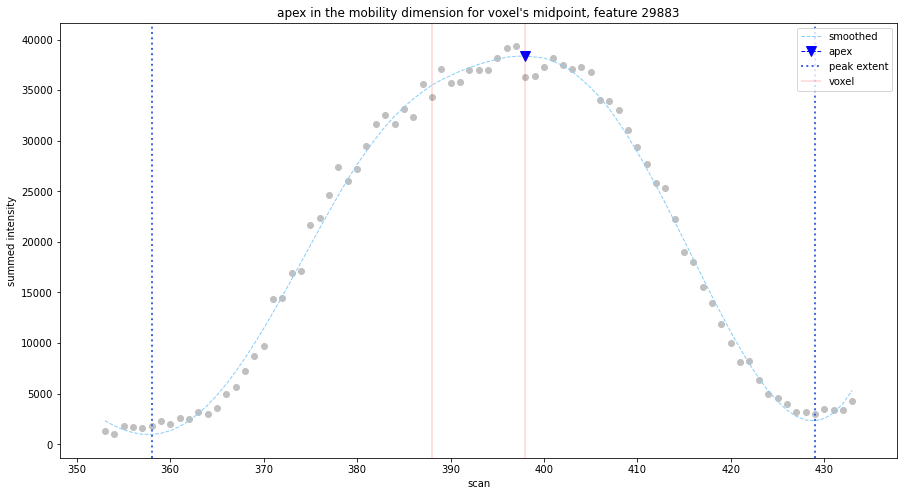

In [29]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the flattened points
plt.scatter(scan_df.scan, scan_df.intensity, c='silver')
# plot the smoothed points
plt.plot(scan_df.scan, scan_df.filtered_intensity, marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed')

plt.plot(selected_feature.scan_apex, scan_df[scan_df.scan==selected_feature.scan_apex].clipped_filtered_intensity, marker='v', color='blue', linestyle='--', linewidth=1, ms=10, label='apex')

plt.axvline(x=selected_feature.scan_lower, linestyle=':', color='royalblue', linewidth=2, label='peak extent')
plt.axvline(x=selected_feature.scan_upper, linestyle=':', color='royalblue', linewidth=2)

plt.axvline(x=selected_feature.voxel_metadata_d['scan_lower'], linestyle='-', color='red', linewidth=0.25, label='voxel')
plt.axvline(x=selected_feature.voxel_metadata_d['scan_upper'], linestyle='-', color='red', linewidth=0.25)

plt.title('apex in the mobility dimension for voxel\'s midpoint, feature {}'.format(selected_feature.feature_id))
plt.legend()
plt.xlabel("scan")
plt.ylabel("summed intensity")
plt.show()

In [30]:
print(selected_feature.scan_r_squared)

0.9801235239601046


#### isotope extent in retention time

In [31]:
rt_df = pd.DataFrame(selected_feature.rt_df)

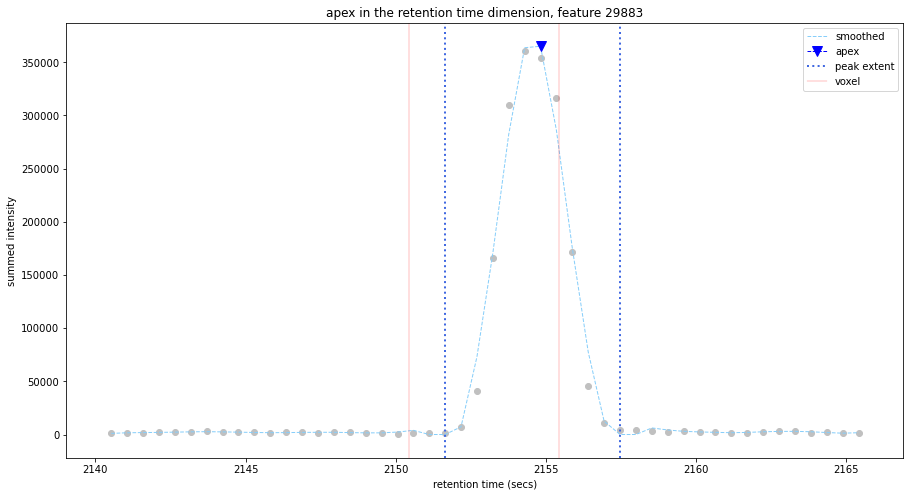

In [32]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the flattened points
plt.scatter(rt_df.retention_time_secs, rt_df.intensity, c='silver')
# plot the smoothed points
plt.plot(rt_df.retention_time_secs, rt_df.clipped_filtered_intensity, marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed')

plt.plot(selected_feature.rt_apex, rt_df[rt_df.retention_time_secs==selected_feature.rt_apex].clipped_filtered_intensity, marker='v', color='blue', linestyle='--', linewidth=1, ms=10, label='apex')

plt.axvline(x=selected_feature.rt_lower, linestyle=':', color='royalblue', linewidth=2, label='peak extent')
plt.axvline(x=selected_feature.rt_upper, linestyle=':', color='royalblue', linewidth=2)

plt.axvline(x=selected_feature.voxel_metadata_d['rt_lower'], linestyle='-', color='red', linewidth=0.25, label='voxel')
plt.axvline(x=selected_feature.voxel_metadata_d['rt_upper'], linestyle='-', color='red', linewidth=0.25)

plt.title('apex in the retention time dimension, feature {}'.format(selected_feature.feature_id))
plt.legend()
plt.xlabel("retention time (secs)")
plt.ylabel("summed intensity")
plt.show()

In [33]:
print(selected_feature.rt_r_squared)

0.9965245554649123


#### feature region in the voxel's most intense frame

In [34]:
# create the colour map to convert intensity to colour
colour_map = cm.batlow_r
norm = colors.LogNorm(vmin=100, vmax=1000, clip=True)


In [35]:
scan_lower = min(selected_feature.scan_lower, selected_feature.voxel_metadata_d['scan_lower'], selected_feature.feature_region_3d_extent['scan_lower'])
scan_upper = max(selected_feature.scan_upper, selected_feature.voxel_metadata_d['scan_upper'], selected_feature.feature_region_3d_extent['scan_upper'])

In [36]:
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
raw_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where frame_type == 0 and retention_time_secs >= {} and retention_time_secs <= {} and scan >= {} and scan <= {} and mz >= {} and mz <= {}".format(selected_feature.rt_apex-20, selected_feature.rt_apex+20, scan_lower, scan_upper, selected_feature.feature_region_3d_extent['mz_lower'], selected_feature.feature_region_3d_extent['mz_upper']), db_conn)
db_conn.close()

In [37]:
voxel_midpoint_rt_lower = selected_feature.voxel_metadata_d['voxel_rt_midpoint'] - 0.5
voxel_midpoint_rt_upper = selected_feature.voxel_metadata_d['voxel_rt_midpoint'] + 0.5
voxel_most_intense_frame_df = raw_df[(raw_df.retention_time_secs >= voxel_midpoint_rt_lower) & (raw_df.retention_time_secs <= voxel_midpoint_rt_upper)]

In [38]:
voxel_mz_lower = selected_feature.voxel_metadata_d['mz_lower']
voxel_mz_upper = selected_feature.voxel_metadata_d['mz_upper']
voxel_scan_lower = selected_feature.voxel_metadata_d['scan_lower']
voxel_scan_upper = selected_feature.voxel_metadata_d['scan_upper']

In [39]:
base_peak_mz_lower = selected_feature.voxel_metadata_d['iso_mz_lower']
base_peak_mz_upper = selected_feature.voxel_metadata_d['iso_mz_upper']
base_peak_scan_lower = selected_feature.feature_region_3d_extent['scan_lower']
base_peak_scan_upper = selected_feature.feature_region_3d_extent['scan_upper']

In [40]:
feature_region_mz_lower = selected_feature.feature_region_3d_extent['mz_lower']
feature_region_mz_upper = selected_feature.feature_region_3d_extent['mz_upper']
feature_region_scan_lower = selected_feature.feature_region_3d_extent['scan_lower']
feature_region_scan_upper = selected_feature.feature_region_3d_extent['scan_upper']
feature_region_rt_lower = selected_feature.feature_region_3d_extent['rt_lower']
feature_region_rt_upper = selected_feature.feature_region_3d_extent['rt_upper']

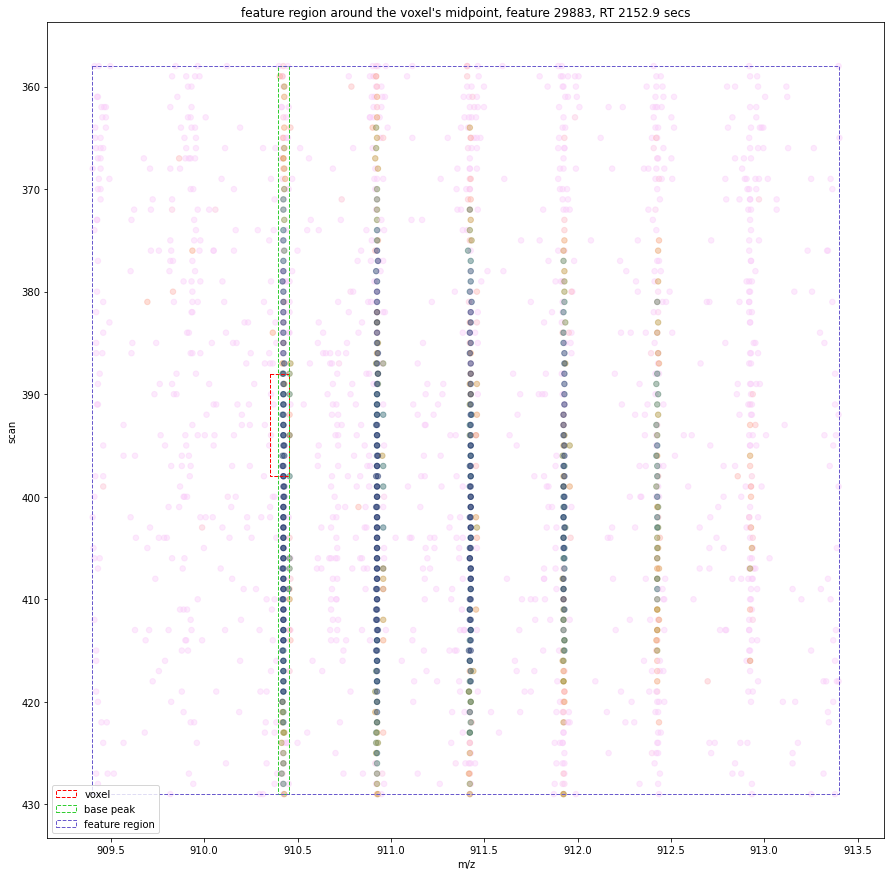

In [41]:
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(voxel_most_intense_frame_df.mz, voxel_most_intense_frame_df.scan, c=voxel_most_intense_frame_df.intensity, cmap=colour_map, norm=norm, alpha=0.4, s=30, linewidths=None, edgecolors=None)
# plt.plot(ap_mz, ap_scan, marker='x', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=5, ms=25, alpha=0.6, label='anchor point')

# draw the voxel
top_left = (voxel_mz_lower,voxel_scan_lower)
width = voxel_mz_upper - voxel_mz_lower
height = voxel_scan_upper - voxel_scan_lower
cuboid_rect = patches.Rectangle(top_left,width,height,linewidth=1.0,linestyle='--',edgecolor='red',facecolor='none',label='voxel')
ax1.add_patch(cuboid_rect)

# draw the base peak
top_left = (base_peak_mz_lower,base_peak_scan_lower)
width = base_peak_mz_upper - base_peak_mz_lower
height = base_peak_scan_upper - base_peak_scan_lower
cuboid_rect = patches.Rectangle(top_left,width,height,linewidth=1.0,linestyle='--',edgecolor='limegreen',facecolor='none',label='base peak')
ax1.add_patch(cuboid_rect)

# draw the feature region for deconvolution
top_left = (feature_region_mz_lower,feature_region_scan_lower)
width = feature_region_mz_upper - feature_region_mz_lower
height = feature_region_scan_upper - feature_region_scan_lower
cuboid_rect = patches.Rectangle(top_left,width,height,linewidth=1.0,linestyle='--',edgecolor='slateblue',facecolor='none',label='feature region')
ax1.add_patch(cuboid_rect)

plt.xlabel("m/z")
plt.ylabel("scan")

nearest = 0.5
range_l = round(voxel_most_intense_frame_df.mz.min() / nearest) * nearest
range_u = round(voxel_most_intense_frame_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

nearest = 10.0
range_l = round(voxel_most_intense_frame_df.scan.min() / nearest) * nearest
range_u = round(voxel_most_intense_frame_df.scan.max() / nearest) * nearest
plt.yticks(np.arange(range_l,range_u+nearest,nearest))

plt.title('feature region around the voxel\'s midpoint, feature {}, RT {} secs'.format(selected_feature.feature_id, round(selected_feature.voxel_metadata_d['voxel_rt_midpoint'],1)))

plt.legend()
plt.gca().invert_yaxis()
plt.show()

#### spectra deconvolution

In [42]:
feature_region_raw_df = raw_df[(raw_df.mz >= feature_region_mz_lower) & (raw_df.mz <= feature_region_mz_upper) & (raw_df.scan >= feature_region_scan_lower) & (raw_df.scan <= feature_region_scan_upper) & (raw_df.retention_time_secs >= feature_region_rt_lower) & (raw_df.retention_time_secs <= feature_region_rt_upper)].copy()
feature_region_raw_df['normalised_intensity'] = feature_region_raw_df.intensity / feature_region_raw_df.intensity.max()

In [43]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Rescale to values between 0 and 1
tableau20_mpl = tableau20.copy()
for i in range(len(tableau20_mpl)):  
    r, g, b = tableau20_mpl[i]  
    tableau20_mpl[i] = (r / 255., g / 255., b / 255.)

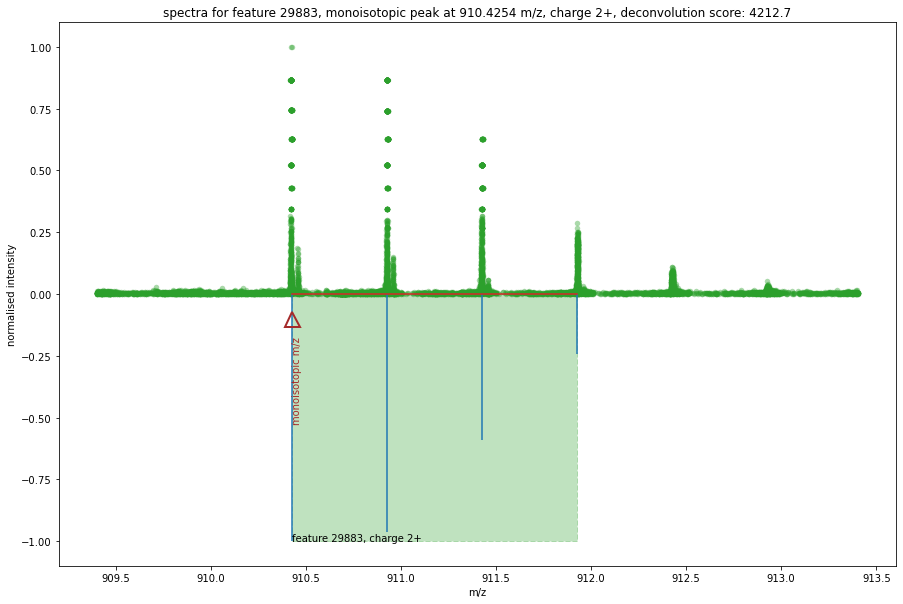

In [45]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

# plot the raw data
ax.scatter(feature_region_raw_df.mz, feature_region_raw_df.normalised_intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4)

# plot the feature's bounding rectangle
envelope = json.loads(selected_feature.envelope)
env_width = envelope[-1][0] - envelope[0][0]
rect_colour = tableau20_mpl[4]
rect = patches.Rectangle((envelope[0][0],0),env_width,-1.0,linewidth=1,linestyle=(0,(5,2)),edgecolor=rect_colour+(0.3,),facecolor=rect_colour+(0.3,),fill=True)
ax.add_patch(rect)
ax.text(x=envelope[0][0], y=-1.0, s='feature {}, charge {}+'.format(selected_feature.feature_id, selected_feature.charge))

# determine the peaks from the envelope
envelope_df = pd.DataFrame(envelope, columns=['mz','intensity'])
envelope_df['normalised_intensity'] = envelope_df.intensity / envelope_df.intensity.max()

# plot the peaks from deconvolution
markerline, stemlines, baseline = ax.stem(envelope_df.mz, -envelope_df.normalised_intensity, markerfmt=" ", use_line_collection=True)

# show the monoisotopic m/z determined by deconvolution
ax.plot(selected_feature.mono_mz, -0.1, marker='^', markerfacecolor='none', markeredgecolor='brown', linestyle='', markeredgewidth=2, ms=15)
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax.text(selected_feature.mono_mz, -0.35, "monoisotopic m/z", **text_style, rotation='vertical')

nearest = 0.5
range_l = round(feature_region_raw_df.mz.min() / nearest) * nearest
range_u = round(feature_region_raw_df.mz.max() / nearest) * nearest
ax.set_xticks(np.arange(range_l,range_u+nearest,nearest))

ax.set_xlabel('m/z')
ax.set_ylabel('normalised intensity')

ax.set_title('spectra for feature {}, monoisotopic peak at {} m/z, charge {}+, deconvolution score: {}'.format(selected_feature.feature_id, round(selected_feature.mono_mz,4), selected_feature.charge, round(selected_feature.deconvolution_score,1)))

plt.show()